In [1]:
#
# In this notebook we examine the roles of storm oranization (size) and storm localization
#
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import binned_statistic, binned_statistic_2d, pearsonr, linregress
from src.regions import *
from src.pf_stats import *
from src.plotting import *

In [91]:
#
# Data is loaded. Only PFs with MaxPr>5 considered for localization calculations
#
regions = [cio_region(), wmp_region()]
df = pd.concat(
    [load_pf_stats(r) for r in regions], 
    axis=0
)

Pearson correlation (r): -0.104
R^2: 0.011
P-value: 0.000e+00


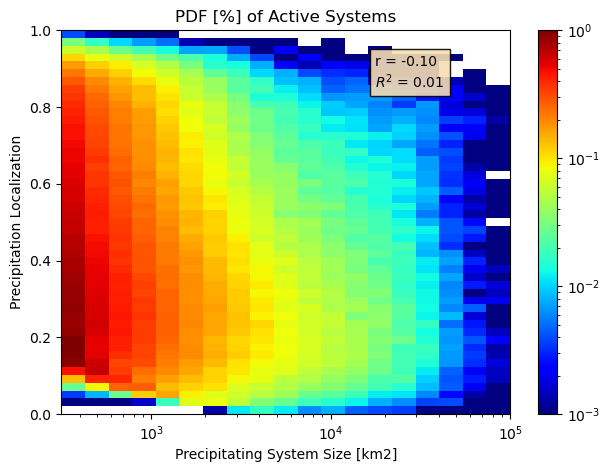

In [92]:
#
# We want to show that organization and localization are weakly correlated
#
active_rain_id = (df['max_precip'] >= 5) & (df['num_convective_pixels']>=1)
active_df = df.where(active_rain_id)
area = active_df['num_pixels'] * 25
loc = active_df['largest_5mmhr_cluster_precip_8conn']/active_df['total_precip']

area_bins = np.logspace(2.5, 5, 20)
loc_bins = np.linspace(0, 1, 50)

count = binned_statistic_2d(
    x=loc, 
    y=area, 
    values=None, 
    statistic='count',
    bins=[loc_bins, area_bins]
).statistic

pdf = 100*count / count.sum()

x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)

c = (
    plt.pcolormesh(
        x_mesh, 
        y_mesh, 
        pdf, 
        cmap=plt.cm.jet, 
        norm=colors.LogNorm(vmin=1e-3, vmax=1e0)
    )   
)
plt.colorbar(c)
plt.xscale('log')
plt.xlabel('Precipitating System Size [km2]')
plt.ylabel('Precipitation Localization')
plt.title('PDF [%] of Active Systems')



# --- NEW: Compute Pearson correlation and R^2 ---
# Drop any NaNs to avoid errors
mask = (~area.isna()) & (~loc.isna())
corr, p_value = pearsonr(loc[mask], area[mask])
r_squared = corr**2

# Print or display the results
print(f"Pearson correlation (r): {corr:.3f}")
print(f"R^2: {r_squared:.3f}")
print(f"P-value: {p_value:.3e}")

# If you want to show it on the plot:
plt.text(
    0.7, 0.85, 
    f"r = {corr:.2f}\n$R^2$ = {r_squared:.2f}",
    transform=plt.gca().transAxes,
    bbox=dict(facecolor='wheat', alpha=0.9)
)
plt.tight_layout(pad=1)
# save_figure(plt.gcf(), 'area_localization_pdf')

In [143]:
df['mean_longitude'].min()

60.0

Pearson correlation (r): 0.860
R^2: 0.739
P-value: 0.000e+00


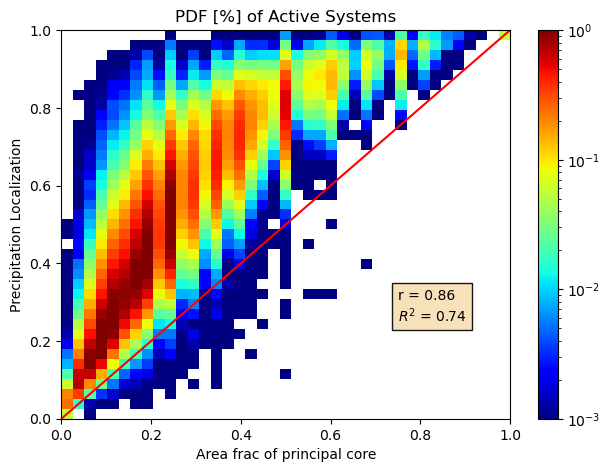

In [109]:
#
# We want to show that localization and area fraction of largest cluster are weakly correlated
#
active_rain_id = (df['max_precip'] >= 5) & (df['num_convective_pixels']>=1)
active_df = df.where(active_rain_id)
area = active_df['largest_5mmhr_cluster_size_8conn']/active_df['num_pixels']
loc = active_df['largest_5mmhr_cluster_precip_8conn']/active_df['total_precip']

area_bins = np.linspace(0, 1, 40)
loc_bins = np.linspace(0, 1, 40)

count = binned_statistic_2d(
    x=loc, 
    y=area, 
    values=None, 
    statistic='count',
    bins=[loc_bins, area_bins]
).statistic

pdf = 100*count / count.sum()

x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)

c = (
    plt.pcolormesh(
        x_mesh, 
        y_mesh, 
        pdf, 
        cmap=plt.cm.jet, 
        norm=colors.LogNorm(vmin=1e-3, vmax=1e0)
    )   
)

plt.plot([0,1], [0,1], color='red')
plt.colorbar(c)
plt.xlabel('Area frac of principal core')
plt.ylabel('Precipitation Localization')
plt.title('PDF [%] of Active Systems')



# --- NEW: Compute Pearson correlation and R^2 ---
# Drop any NaNs to avoid errors
mask = (~area.isna()) & (~loc.isna())
corr, p_value = pearsonr(loc[mask], area[mask])
r_squared = corr**2

# Print or display the results
print(f"Pearson correlation (r): {corr:.3f}")
print(f"R^2: {r_squared:.3f}")
print(f"P-value: {p_value:.3e}")

# If you want to show it on the plot:
plt.text(
    0.75, 0.25, 
    f"r = {corr:.2f}\n$R^2$ = {r_squared:.2f}",
    transform=plt.gca().transAxes,
    bbox=dict(facecolor='wheat', alpha=0.9)
)

plt.xlim(0,1)
plt.ylim(0,1)
plt.tight_layout(pad=1)
save_figure(plt.gcf(), 'area_frac_localization_pdf')

Text(0.5, 1.0, 'Max Precip [mm/hr]')

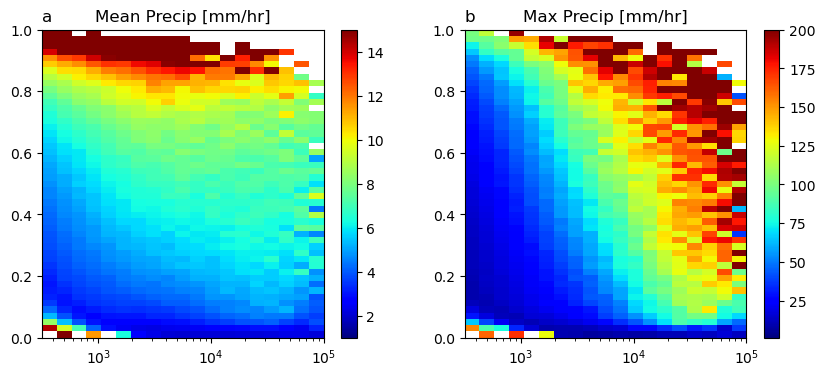

In [133]:
#
# We want to show that organization and localization both impact mean Pr and MaxPr
#
active_rain_id = (df['max_precip'] >= 5) & (df['num_convective_pixels']>=1)
active_df = df.where(active_rain_id)
area = active_df['num_pixels'] * 25
loc = active_df['largest_5mmhr_cluster_precip_4conn']/active_df['total_precip']

area_bins = np.logspace(2.5, 5, 20)
loc_bins = np.linspace(0, 1, 50)

mean_pr = active_df['total_precip']/active_df['num_pixels']
max_pr = active_df['max_precip']

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))
x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)

#
# Plot Mean PR
#
ax = axs[0]
stat = binned_statistic_2d(
    loc, 
    area, 
    mean_pr, 
    bins=[loc_bins, area_bins]
).statistic

c = ax.pcolormesh(
    x_mesh,
    y_mesh,
    stat, 
    cmap=plt.cm.jet, 
    norm=colors.Normalize(vmin=1, vmax=15)
)
cb = fig.colorbar(c)
ax.set_xscale('log')
ax.set_title('a', loc='left')
ax.set_title('Mean Precip [mm/hr]')

#
# Plot Mean PR
#
ax = axs[1]
stat = binned_statistic_2d(
    loc, 
    area, 
    max_pr, 
    bins=[loc_bins, area_bins]
).statistic

c = ax.pcolormesh(
    x_mesh,
    y_mesh,
    stat, 
    cmap=plt.cm.jet, 
    norm=colors.Normalize(vmin=1, vmax=200)
)
cb = fig.colorbar(c)
ax.set_xscale('log')
ax.set_title('b', loc='left')
ax.set_title('Max Precip [mm/hr]')


Pearson correlation (r): -0.342
R^2: 0.117
P-value: 0.000e+00


Text(0.7, 0.85, 'r = -0.34\n$R^2$ = 0.12')

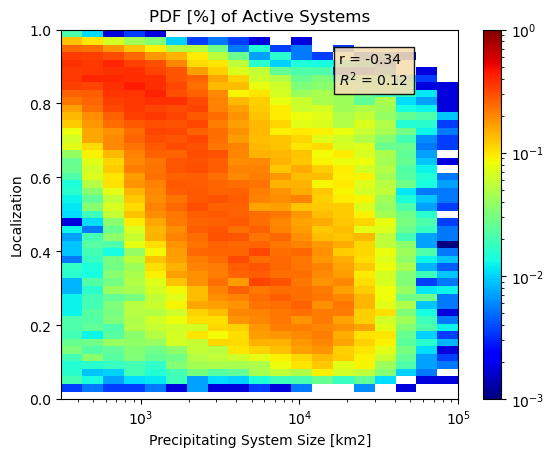

In [59]:
#
# We want to show that organization and localization are weakly correlated
#
active_rain_id = (df['max_precip'] >= 60) & (df['num_convective_pixels']>=1)
active_df = df.where(active_rain_id)
area = active_df['num_pixels'] * 25
loc = active_df['largest_5mmhr_cluster_precip_8conn']/active_df['total_precip']

area_bins = np.logspace(2.5, 5, 20)
loc_bins = np.linspace(0, 1, 50)

count = binned_statistic_2d(
    x=loc, 
    y=area, 
    values=None, 
    statistic='count',
    bins=[loc_bins, area_bins]
).statistic

pdf = 100*count / count.sum()

x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)

c = (
    plt.pcolormesh(
        x_mesh, 
        y_mesh, 
        pdf, 
        cmap=plt.cm.jet, 
        norm=colors.LogNorm(vmin=1e-3, vmax=1e0)
    )   
)
plt.colorbar(c)
plt.xscale('log')
plt.xlabel('Precipitating System Size [km2]')
plt.ylabel('Localization')
plt.title('PDF [%] of Active Systems')



# --- NEW: Compute Pearson correlation and R^2 ---
# Drop any NaNs to avoid errors
mask = (~area.isna()) & (~loc.isna())
corr, p_value = pearsonr(loc[mask], area[mask])
r_squared = corr**2

# Print or display the results
print(f"Pearson correlation (r): {corr:.3f}")
print(f"R^2: {r_squared:.3f}")
print(f"P-value: {p_value:.3e}")

# If you want to show it on the plot:
plt.text(
    0.7, 0.85, 
    f"r = {corr:.2f}\n$R^2$ = {r_squared:.2f}",
    transform=plt.gca().transAxes,
    bbox=dict(facecolor='wheat', alpha=0.9)
)
